In [2]:
import pandas as pd
import numpy as np
import urllib.request
from zipfile import ZipFile
from re import compile
from pathlib import Path
from shutil import rmtree
deis_data = Path('deis_data')
deis_data.mkdir(parents=True, exist_ok=True)

def get_deis_death_url():
    datapattern = compile('http.*DEFUNCIONES_FUENTE_DEIS_2016_.*zip\"\\n\"tags\":\"defunciones\"')
    with urllib.request.urlopen('https://deis.minsal.cl/wp-admin/admin-ajax.php?action=wp_ajax_ninja_tables_public_action&table_id=2889&target_action=get-all-data&default_sorting=manual_sort') as f:
        return datapattern.search(f.read().decode().replace(',','\n')).group().replace('\\', '').split('"')[0]

def get_csv_deis():
    url = get_deis_death_url()
    urllib.request.urlretrieve(url, 'deis_data/' + url.split('/')[-1])
    with ZipFile('deis_data/' + url.split('/')[-1], 'r') as zip_ref:
        zip_ref.extractall('deis_data')
    return url.split('/')[-1][:-3]

def annos(row):
    edad = row['EDAD_CANT']
    tipo = row['EDAD_TIPO']
    if tipo == 1:
        return edad
    elif tipo == 2:
        return edad/12
    elif tipo == 3:
        return edad/365
    elif tipo == 4:
        return edad/365*24
    else:
        return np.nan
deis_csv = 'deis_data/' + get_csv_deis() + 'csv'
columnas = ['ANO_DEF', 'FECHA_DEF', 'GLOSA_SEXO', 'EDAD_TIPO', 'EDAD_CANT', 'CODIGO_COMUNA_RESIDENCIA', 'GLOSA_COMUNA_RESIDENCIA', 'GLOSA_REG_RES', 'DIAG1', 'CAPITULO_DIAG1', 'GLOSA_CAPITULO_DIAG1', 'CODIGO_GRUPO_DIAG1', 'GLOSA_GRUPO_DIAG1', 'CODIGO_CATEGORIA_DIAG1', 'GLOSA_CATEGORIA_DIAG1', 'CODIGO_SUBCATEGORIA_DIAG1', 'GLOSA_SUBCATEGORIA_DIAG1', 'DIAG2', 'CAPITULO_DIAG2', 'GLOSA_CAPITULO_DIAG2', 'CODIGO_GRUPO_DIAG2', 'GLOSA_GRUPO_DIAG2', 'CODIGO_CATEGORIA_DIAG2', 'GLOSA_CATEGORIA_DIAG2', 'CODIGO_SUBCATEGORIA_DIAG2', 'GLOSA_SUBCATEGORIA_DIAG2']
deis = pd.read_csv(deis_csv, sep=';', parse_dates=[1], header=None, names=columnas, index_col=False, encoding='latin-1')
deis.set_index(['FECHA_DEF'], inplace=True)
deis.sort_index(inplace=True)
# CODIGO_CATEGORIA_DIAG1 U07 > covid19
rmtree(deis_data)
deis['EDAD_ANOS'] = deis.apply(annos, axis = 1)
deis['ANO_DEF'] = deis['ANO_DEF'].astype('int32')
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 999]
bins_10s = [0, 10, 20, 30, 40, 50, 60, 70, 80, 999]
labels = ['00-04', '05-09', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']
labels_10s = ['00-09', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
deis['agerange'] = pd.cut(deis.EDAD_ANOS, bins, labels=labels, include_lowest=True, right=False)
deis['agerange_10s'] = pd.cut(deis.EDAD_ANOS, bins_10s, labels=labels_10s, include_lowest=True, right=False)


/var/folders/33/kgv35mp95jd5fxbx_lqm8mkm0000gn/T/ipykernel_84267/1025095267.py:38: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  deis = pd.read_csv(deis_csv, sep=';', parse_dates=[1], header=None, names=columnas, index_col=False, encoding='latin-1')


In [3]:
import calendar
import os

import aesara.tensor as at
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (at.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / at.sqrt(n_out)
        out = at.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coord(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)


# default figure sizes
figsize = (10, 5)

# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]


In [4]:
deis.dtypes

ANO_DEF                         int32
GLOSA_SEXO                     object
EDAD_TIPO                       int64
EDAD_CANT                       int64
CODIGO_COMUNA_RESIDENCIA        int64
GLOSA_COMUNA_RESIDENCIA        object
GLOSA_REG_RES                  object
DIAG1                          object
CAPITULO_DIAG1                 object
GLOSA_CAPITULO_DIAG1           object
CODIGO_GRUPO_DIAG1             object
GLOSA_GRUPO_DIAG1              object
CODIGO_CATEGORIA_DIAG1         object
GLOSA_CATEGORIA_DIAG1          object
CODIGO_SUBCATEGORIA_DIAG1      object
GLOSA_SUBCATEGORIA_DIAG1       object
DIAG2                          object
CAPITULO_DIAG2                 object
GLOSA_CAPITULO_DIAG2           object
CODIGO_GRUPO_DIAG2             object
GLOSA_GRUPO_DIAG2              object
CODIGO_CATEGORIA_DIAG2         object
GLOSA_CATEGORIA_DIAG2          object
CODIGO_SUBCATEGORIA_DIAG2      object
GLOSA_SUBCATEGORIA_DIAG2       object
EDAD_ANOS                     float64
agerange    

In [5]:
deis_gruped = pd.pivot_table(deis, values=['EDAD_CANT'], index=['FECHA_DEF'],
                    columns=['GLOSA_SEXO', 'agerange_10s'], aggfunc='count')['EDAD_CANT']
deis_prepandemia = pd.pivot_table(deis.loc[(deis['ANO_DEF'] <= 2019)], values=['EDAD_CANT'], index=['FECHA_DEF'],
                    columns=['GLOSA_SEXO', 'agerange_10s'], aggfunc='count')['EDAD_CANT']
deis_postpandemia = pd.pivot_table(deis.loc[(deis['ANO_DEF'] > 2019)], values=['EDAD_CANT'], index=['FECHA_DEF'],
                    columns=['GLOSA_SEXO', 'agerange_10s'], aggfunc='count')['EDAD_CANT']
deis_gruped = deis_gruped.sum(axis=1).iloc[:-7]#.groupby(pd.Grouper(freq='W')).sum().iloc[1:-1]
deis_prepandemia = deis_prepandemia.sum(axis=1).iloc[:]#.groupby(pd.Grouper(freq='W')).sum().iloc[1:-1]
deis_postpandemia = deis_postpandemia.sum(axis=1).iloc[:-7]#.groupby(pd.Grouper(freq='W')).sum().iloc[:-1]

In [6]:
deis_postpandemia

FECHA_DEF
2020-01-01    319
2020-01-02    292
2020-01-03    325
2020-01-04    315
2020-01-05    285
             ... 
2022-10-01    330
2022-10-02    359
2022-10-03    347
2022-10-04    338
2022-10-05    335
Length: 1009, dtype: int64

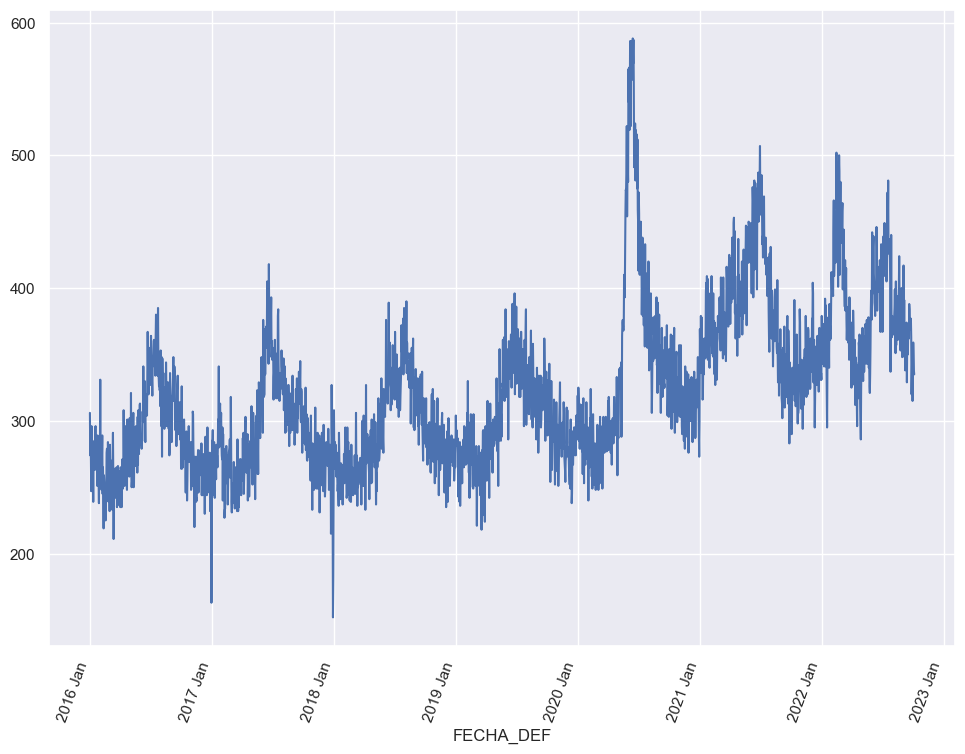

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data=deis_gruped)
format_x_axis(ax)

In [8]:
defu = pd.DataFrame(deis_prepandemia, columns=['defunciones'])
defu['año'] = defu.index.year
defu['mes'] = defu.index.month
defu['dia'] = defu.index.day_of_year

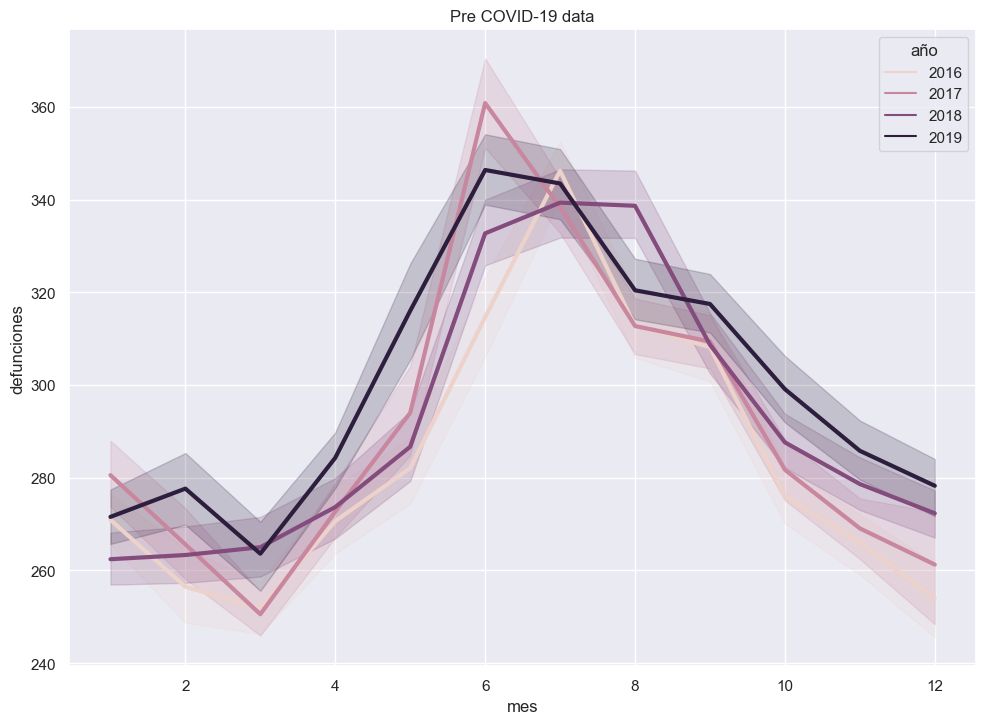

In [9]:
ax = sns.lineplot(data=defu, x="mes", y="defunciones", hue="año", lw=3)
ax.set(title="Pre COVID-19 data");

<AxesSubplot:xlabel='año', ylabel='defunciones'>

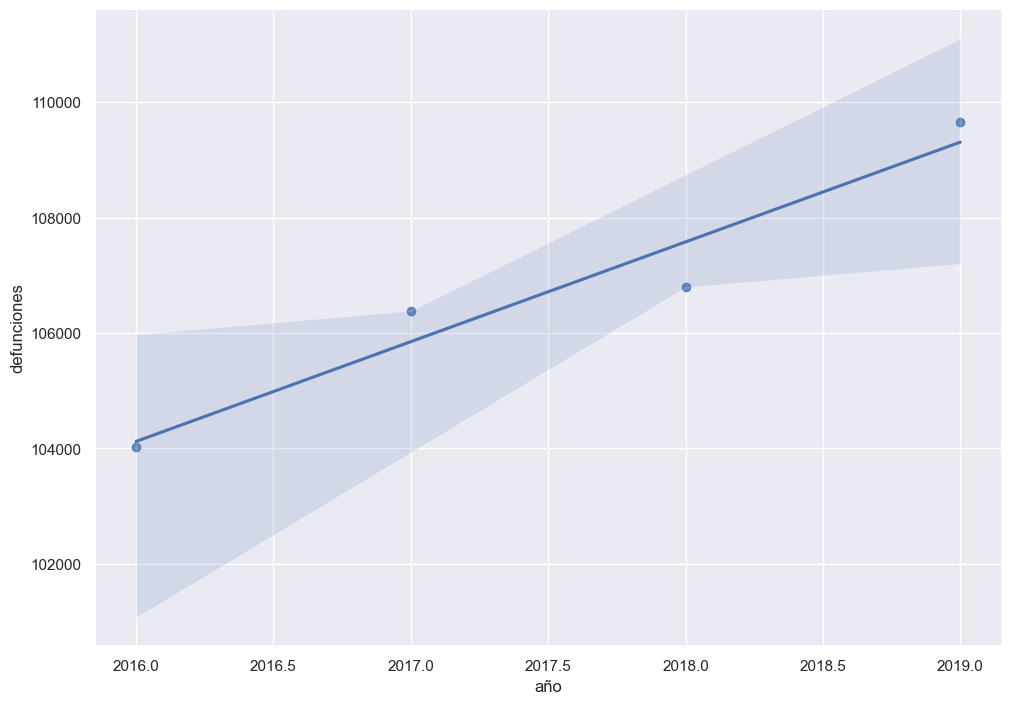

In [10]:
annual_deaths = pd.DataFrame(defu.groupby("año")["defunciones"].sum()).reset_index()
sns.regplot(x="año", y="defunciones", data=annual_deaths)

In [11]:
slope, intercept = np.polyfit(annual_deaths["año"], annual_deaths["defunciones"], 1)
print(f"{slope:.0f} defunciones/año")


1730 defunciones/año


In [12]:
with pm.Model(coords={"month": month_strings}) as model:

    # observed predictors and outcome
    month = pm.MutableData("month", deis_prepandemia.index.month.to_numpy(), dims='t')
    time = pm.MutableData("time", np.array(list(range(len(deis_prepandemia)))), dims='t')
    deaths = pm.MutableData("deaths", deis_prepandemia.to_numpy(), dims='t')
    # priors
    intercept = pm.Normal("intercept", 300, 10)
    month_mu = ZeroSumNormal("month mu", sigma=200, dims="month")
    linear_trend = pm.TruncatedNormal("linear trend", 0, 0.1, lower=0)

    # the actual linear model
    mu = pm.Deterministic(
        "mu",
        intercept + (linear_trend * time) + month_mu[month - 1],
    )
    sigma = pm.HalfNormal("sigma", 1)
    # likelihood
    pm.TruncatedNormal("obs", mu=mu, sigma=sigma, lower=0, observed=deaths, dims='t')


$$\Large Defunciones =  TendenciaAnual * Tiempo + CoeficienteCicloMensual[12] + intercepto $$


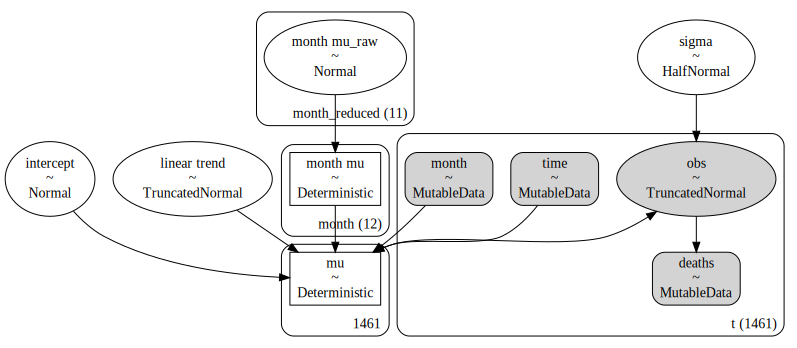

In [13]:
pm.model_to_graphviz(model)

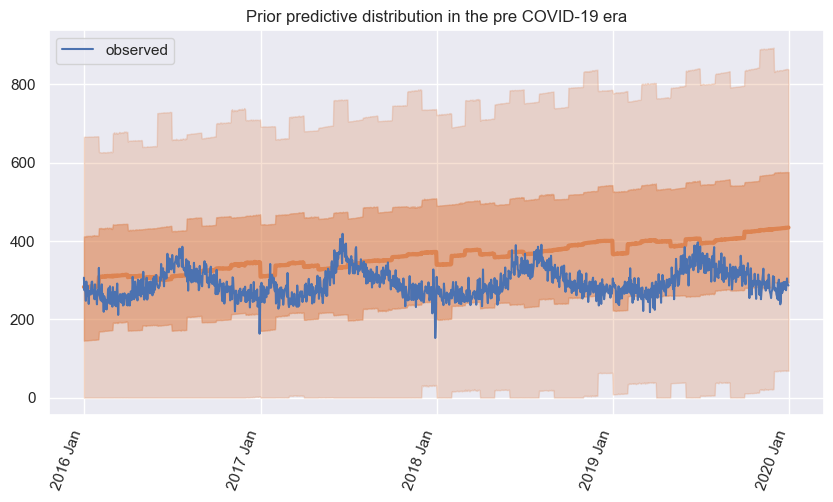

In [14]:
with model:
    idata = pm.sample_prior_predictive(random_seed=42)


fig, ax = plt.subplots(figsize=figsize)

plot_xY(deis_prepandemia.index, idata.prior_predictive["obs"], ax)
format_x_axis(ax)
ax.plot(deis_prepandemia.index, deis_prepandemia, label="observed")
ax.set(title="Prior predictive distribution in the pre COVID-19 era")
plt.legend();


In [15]:
with model:
    idata.extend(pm.sample(random_seed=42))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, month mu_raw, linear trend, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


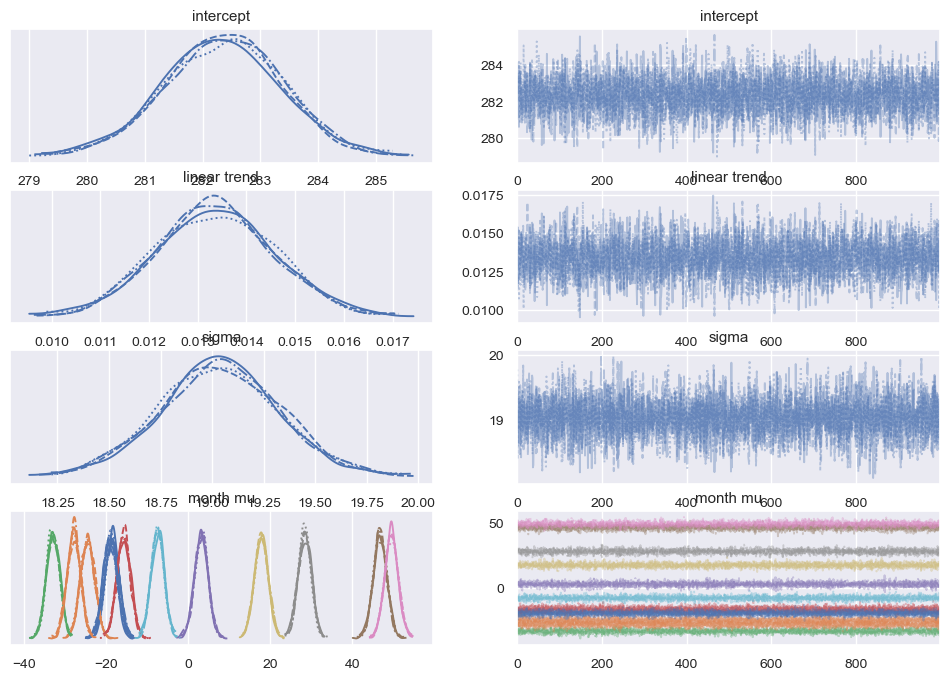

In [16]:
az.plot_trace(idata, var_names=["~mu", "~month mu_raw"]);

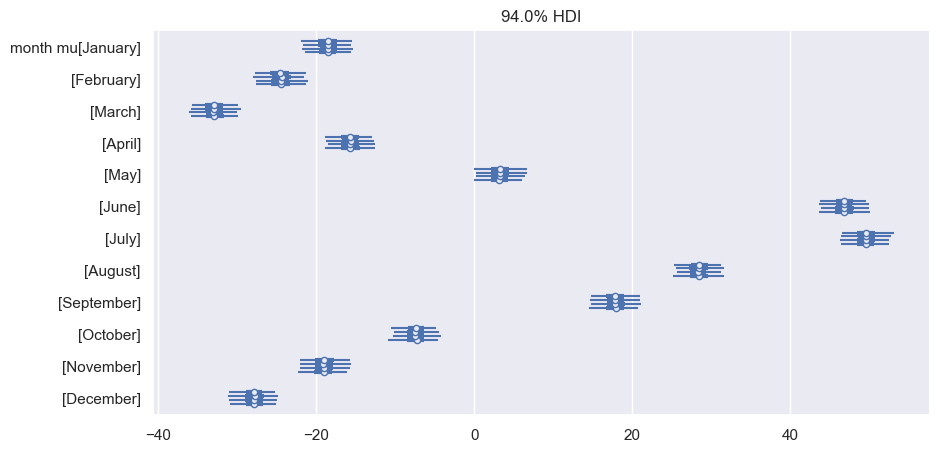

In [17]:
az.plot_forest(idata.posterior, var_names="month mu", figsize=figsize);

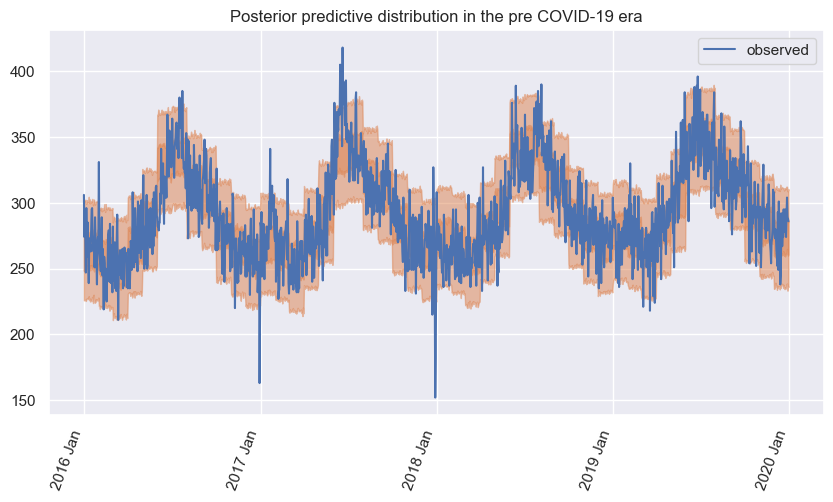

In [18]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=42))


fig, ax = plt.subplots(figsize=figsize)

az.plot_hdi(deis_prepandemia.index, idata.posterior_predictive["obs"], hdi_prob=0.5, smooth=False)
az.plot_hdi(deis_prepandemia.index, idata.posterior_predictive["obs"], hdi_prob=0.95, smooth=False)
ax.plot(deis_prepandemia.index, deis_prepandemia, label="observed")
format_x_axis(ax)
ax.set(title="Posterior predictive distribution in the pre COVID-19 era")
plt.legend();


In [19]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

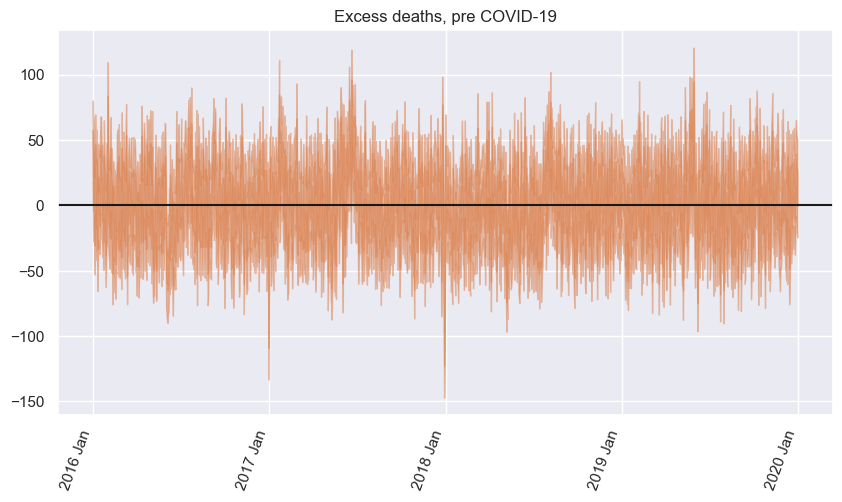

In [20]:
# convert deaths into an XArray object with a labelled dimension to help in the next step
deaths = xr.DataArray(deis_prepandemia.to_numpy(), dims=["t"])

# do the calculation by taking the difference
excess_deaths = deaths - idata.posterior_predictive["obs"]

fig, ax = plt.subplots(figsize=figsize)
# the transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
az.plot_hdi(deis_prepandemia.index, excess_deaths.transpose(..., "t"), hdi_prob=0.5, smooth=False)
az.plot_hdi(deis_prepandemia.index, excess_deaths.transpose(..., "t"), hdi_prob=0.95, smooth=False)
format_x_axis(ax)
ax.axhline(y=0, color="k")
ax.set(title="Excess deaths, pre COVID-19");
cumsum_excess_deaths = excess_deaths.cumsum(dim="t")

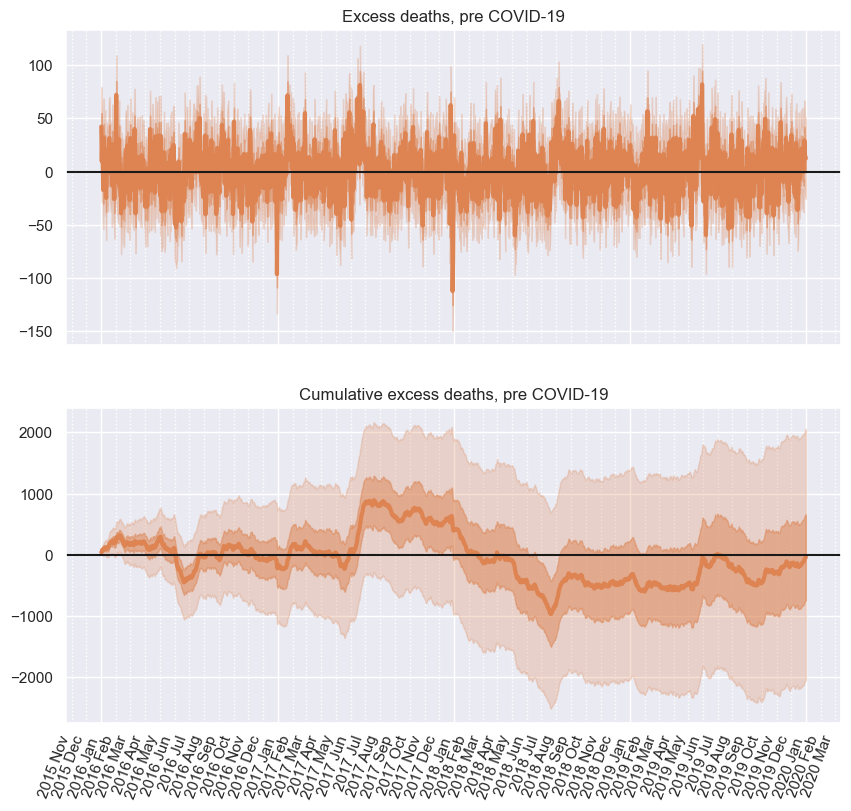

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(figsize[0], 9), sharex=True)

# Plot the excess deaths
# The transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
plot_xY(deis_prepandemia.index, excess_deaths.transpose(..., "t"), ax[0])
format_x_axis(ax[0], minor=True)
ax[0].axhline(y=0, color="k")
ax[0].set(title="Excess deaths, pre COVID-19")

# Plot the cumulative excess deaths
plot_xY(deis_prepandemia.index, cumsum_excess_deaths.transpose(..., "t"), ax[1])
format_x_axis(ax[1], minor=True)
ax[1].axhline(y=0, color="k")
ax[1].set(title="Cumulative excess deaths, pre COVID-19");


In [22]:
with model:
    pm.set_data(
        {
            "month": deis_postpandemia.index.month.to_numpy(),
            "time": np.array(list(range(len(deis_postpandemia)))),
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        idata, var_names=["obs"], random_seed=42
    )


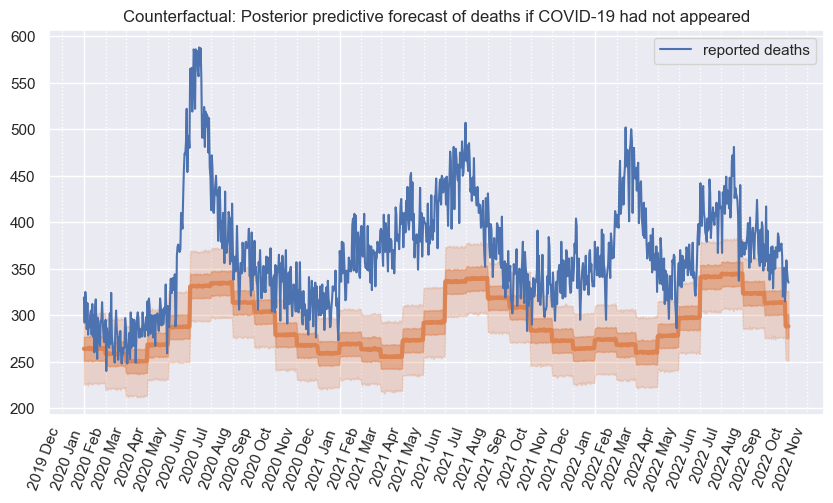

In [23]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(deis_postpandemia.index, counterfactual.posterior_predictive["obs"], ax)
format_x_axis(ax, minor=True)
ax.plot(deis_postpandemia.index, deis_postpandemia, label="reported deaths")

ax.set(title="Counterfactual: Posterior predictive forecast of deaths if COVID-19 had not appeared")
plt.legend();


In [24]:
deis_postpandemia.cumsum()

FECHA_DEF
2020-01-01       319
2020-01-02       611
2020-01-03       936
2020-01-04      1251
2020-01-05      1536
               ...  
2022-10-01    368497
2022-10-02    368856
2022-10-03    369203
2022-10-04    369541
2022-10-05    369876
Length: 1009, dtype: int64

In [25]:
# convert deaths into an XArray object with a labelled dimension to help in the next step
deaths = xr.DataArray(deis_postpandemia.to_numpy(), dims=["t"])

# do the calculation by taking the difference
excess_deaths = deaths - counterfactual.posterior_predictive["obs"]


In [26]:
cumsum = excess_deaths.cumsum(dim="t")


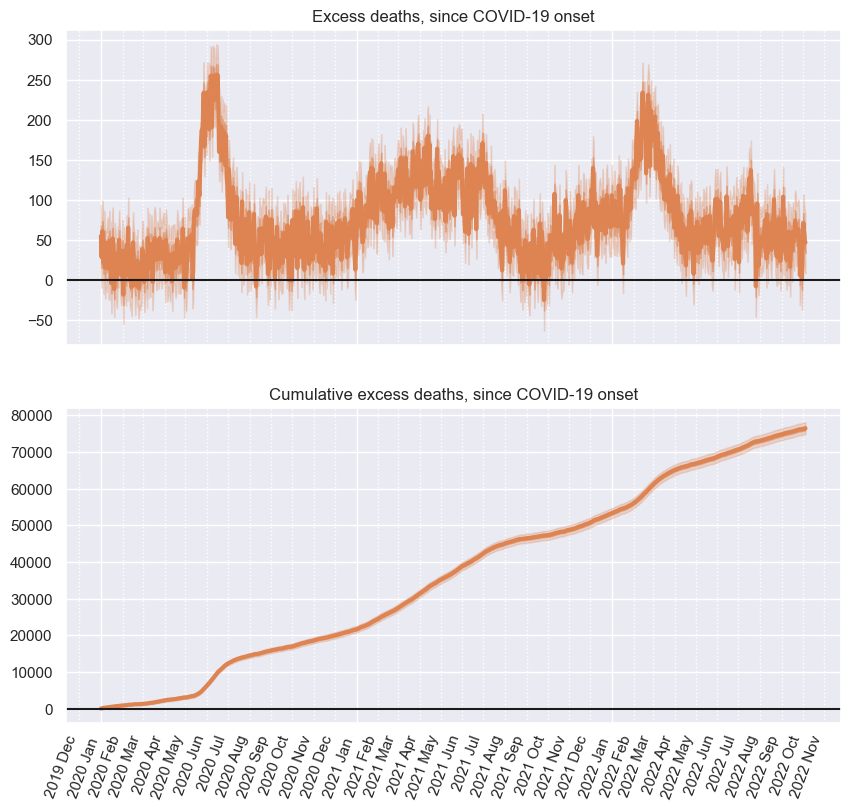

In [27]:
deis_postpandemia_covid = pd.pivot_table(deis.loc[(deis['ANO_DEF'] > 2019) & (deis['CODIGO_CATEGORIA_DIAG1'] == 'U07')], values=['EDAD_CANT'], index=['FECHA_DEF'],
                    columns=['GLOSA_SEXO', 'agerange_10s'], aggfunc='count')['EDAD_CANT']
deis_postpandemia_covid = deis_postpandemia_covid.sum(axis=1).iloc[:-7]#.groupby(pd.Grouper(freq='W')).sum().iloc[:-1]

fig, ax = plt.subplots(2, 1, figsize=(figsize[0], 9), sharex=True)

# Plot the excess deaths
# The transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
plot_xY(deis_postpandemia.index, excess_deaths.transpose(..., "t"), ax[0])
format_x_axis(ax[0], minor=True)
ax[0].axhline(y=0, color="k")
ax[0].set(title="Excess deaths, since COVID-19 onset")
#ax[0].plot(deis_postpandemia_covid.index, deis_postpandemia_covid, color="C2", lw=3)

# Plot the cumulative excess deaths
plot_xY(deis_postpandemia.index, cumsum.transpose(..., "t"), ax[1])
format_x_axis(ax[1], minor=True)
ax[1].axhline(y=0, color="k")
ax[1].set(title="Cumulative excess deaths, since COVID-19 onset");
#ax[1].plot(deis_postpandemia_covid.index, deis_postpandemia_covid.cumsum(), color="C2", lw=3)


In [28]:
quantiles = cumsum.transpose(..., "t").quantile((0.05, 0.95), dim=("chain", "draw")).transpose()
quantiles[-1]

<xarray.DataArray (quantile: 2)>
array([75074.65673508, 77822.39123002])
Coordinates:
    t         int64 1008
  * quantile  (quantile) float64 0.05 0.95

In [29]:
deis_postpandemia_covid.sum()

61328

In [30]:
deis_postpandemia_nocovid = pd.pivot_table(deis.loc[(deis['ANO_DEF'] > 2019) & (deis['CODIGO_CATEGORIA_DIAG1'] != 'U07')], values=['EDAD_CANT'], index=['FECHA_DEF'],
                    columns=['GLOSA_SEXO', 'agerange_10s'], aggfunc='count')['EDAD_CANT']
deis_postpandemia_nocovid = deis_postpandemia_nocovid.sum(axis=1).iloc[:-7]#.groupby(pd.Grouper(freq='W')).sum().iloc[:-1]
# convert deaths into an XArray object with a labelled dimension to help in the next step
deaths = xr.DataArray(deis_postpandemia_nocovid.to_numpy(), dims=["t"])

# do the calculation by taking the difference
excess_deaths = deaths - counterfactual.posterior_predictive["obs"]
cumsum = excess_deaths.cumsum(dim="t")


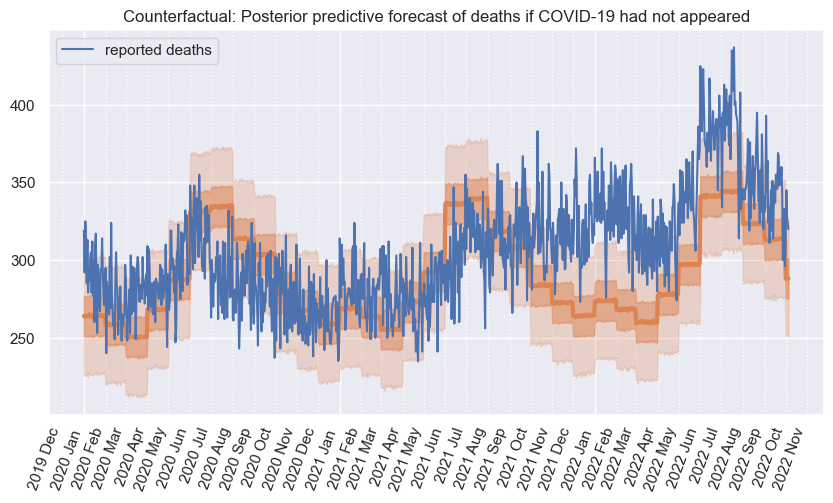

In [31]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(deis_postpandemia_nocovid.index, counterfactual.posterior_predictive["obs"], ax)
format_x_axis(ax, minor=True)
ax.plot(deis_postpandemia_nocovid.index, deis_postpandemia_nocovid, label="reported deaths")

ax.set(title="Counterfactual: Posterior predictive forecast of deaths if COVID-19 had not appeared")
plt.legend();


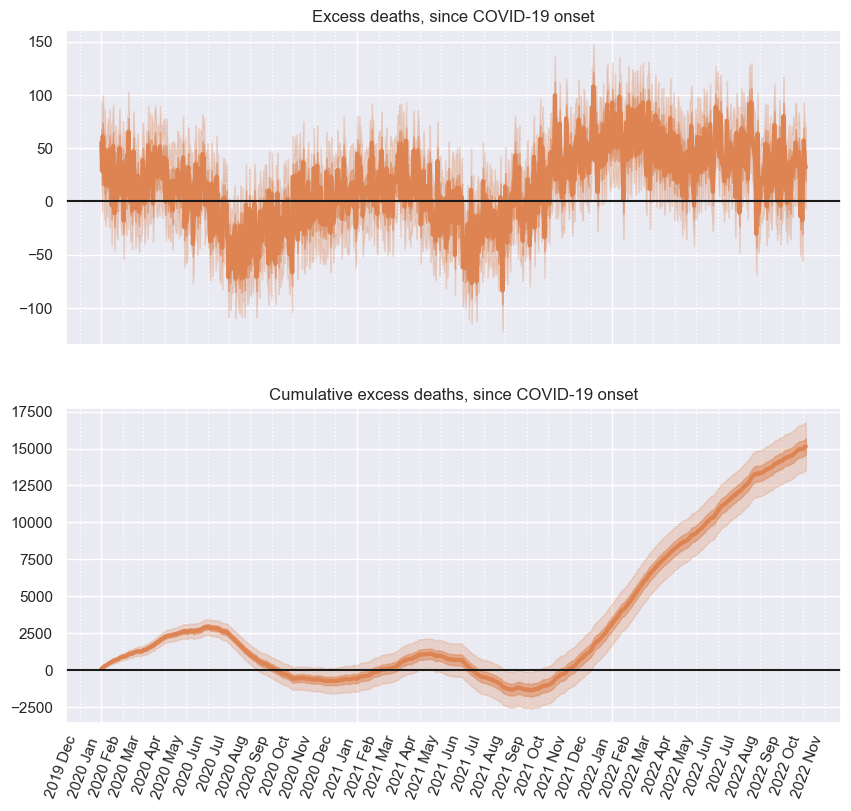

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(figsize[0], 9), sharex=True)

# Plot the excess deaths
# The transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
plot_xY(deis_postpandemia_nocovid.index, excess_deaths.transpose(..., "t"), ax[0])
format_x_axis(ax[0], minor=True)
ax[0].axhline(y=0, color="k")
ax[0].set(title="Excess deaths, since COVID-19 onset")

# Plot the cumulative excess deaths
plot_xY(deis_postpandemia_nocovid.index, cumsum.transpose(..., "t"), ax[1])
format_x_axis(ax[1], minor=True)
ax[1].axhline(y=0, color="k")
ax[1].set(title="Cumulative excess deaths, since COVID-19 onset");
